# Walmart - Store Sales Forecasting
The purpose of this [problem](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) solution is to predict weekly sales per store and departments. <br/>

Our data contains: <br/> <br/>
__Stores__

* This file contains anonymized information about the 45 stores, indicating the type and size of store.

__Train__


* Store - the store number
* Dept - the department number
* Date - the week
* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week

__Features__


* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week

First, let's import all we need:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import random
import xgboost as xg
import datetime
import numpy as np
from IPython.core import display as ICD
from sklearn.metrics import mean_squared_error as MSE
import warnings

warnings.filterwarnings('ignore')

Now, let's read the data

In [2]:
#Get path of all the data frames and read them
DataFrames = list(map(lambda x: pd.read_csv(os.path.join('data',x)), os.listdir('data'))) 

features = DataFrames[0]
sampleSubmission = DataFrames[1]
stores = DataFrames[2]
data = DataFrames[4]

and show it

In [3]:
#Plot the data
print('Data:')
ICD.display(data.head())
print('\nFeatures:')
ICD.display(features.head())
print('\nStores:')
ICD.display(stores.head())

Data:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False



Features:


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False



Stores:


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Sweet! now we can move to analysis & cleaning level. <br/>
# Preprocessing
Now an inner join is made between all the dataframes in order to arrive at one neat trainset. <br/>
![](https://docs.microsoft.com/en-us/power-query/images/inner-join-operation.png)
> Inner join illustration example

<br/>
Then we will convert the categorical and hierarchical data to numeric data.

In [4]:
# Merging
data = pd.merge(data,features,on=['Store','Date','IsHoliday'])
data = pd.merge(data,stores,on=['Store'])

# Convert from string to date time
data['Date'] = pd.to_datetime(data['Date'])

# Add week number of the year (1..52) column an year column
data['Week'] = data['Date'].dt.isocalendar().week
data['Year'] = data['Date'].dt.year

#Convert date to index and drop the date column
data.index = data['Date']
data = data.drop(columns = ['Date'])

# Convert the categorical IsHoliday colunm and the hierarchical Type column to numbers
data['IsHoliday'].replace({False: 0, True: 1}, inplace=True)
data['Type'].replace({'A': 3, 'B': 2, 'C': 1}, inplace=True) # A > B > C

data = data.sort_index()

data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,3,151315,5,2010
2010-02-05,35,3,14612.19,0,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,2,103681,5,2010
2010-02-05,35,4,26323.15,0,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,2,103681,5,2010
2010-02-05,35,5,36414.63,0,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,2,103681,5,2010
2010-02-05,35,6,11437.81,0,27.19,2.784,NaN,NaN,NaN,NaN,NaN,135.352461,9.262,2,103681,5,2010


# Null analysis
We will check how many missing entries the data contains for each column.

In [5]:
for i in data.columns:
    print("{}: {} / {}.".format(
            i,
            data[i].isna().sum(),
            len(data)
    ))
    
print("\n")
    
for i in range(1,6):
    print("MarkDown{} correlation with Weekly_Sales: {}.".format(i,data[data['MarkDown'+ str(i)].isnull() == False]['MarkDown'+ str(i)].corr(data[data['MarkDown'+ str(i)].isnull() == False]['Weekly_Sales'])))

Store: 0 / 421570.
Dept: 0 / 421570.
Weekly_Sales: 0 / 421570.
IsHoliday: 0 / 421570.
Temperature: 0 / 421570.
Fuel_Price: 0 / 421570.
MarkDown1: 270889 / 421570.
MarkDown2: 310322 / 421570.
MarkDown3: 284479 / 421570.
MarkDown4: 286603 / 421570.
MarkDown5: 270138 / 421570.
CPI: 0 / 421570.
Unemployment: 0 / 421570.
Type: 0 / 421570.
Size: 0 / 421570.
Week: 0 / 421570.
Year: 0 / 421570.


MarkDown1 correlation with Weekly_Sales: 0.08525115648106883.
MarkDown2 correlation with Weekly_Sales: 0.024129610651030226.
MarkDown3 correlation with Weekly_Sales: 0.060384760388575515.
MarkDown4 correlation with Weekly_Sales: 0.04541440291265181.
MarkDown5 correlation with Weekly_Sales: 0.09036206126432896.


As we see all Markdown columns contain a high amount of Nulls and in addition they have a low correlation with the sales column so it is probably worth deleting them.

In [6]:
data = data.drop(columns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

# Holiday analysis
Four holidays fall within the following weeks in the dataset (not all holidays are in the data): <br/>

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13<br/>
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13<br/>
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13<br/>
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13<br/>

In [7]:
HolidayDf = pd.DataFrame({'Date': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'
                      ,'2010-11-26','2011-11-25','2012-11-23','2013-11-29','2010-12-31','2011-12-30','2012-12-28','2013-12-27'],
              'Holiday': ['Super Bowl']*4 + ['Labor day']*4 + ['Thanksgiving']*4 + ['Christmas']*4})

HolidayDf['Date'] = pd.to_datetime(HolidayDf['Date'])
HolidayDf['Week'] = HolidayDf['Date'].dt.isocalendar().week
HolidayDf['Year'] = HolidayDf['Date'].dt.year

In [8]:
def SumOfHolidays(Week,Year):
    return data[(data['Week'] == Week) & (data['Year'] == Year)].iloc[:,0].count()

HolidayDf['Count'] = HolidayDf.apply(lambda x: SumOfHolidays(x.Week,x.Year),axis = 1)
HolidayDf = HolidayDf.drop(columns= ['Date'])


HolidayDf

,Holiday,Week,Year,Count
0,Super Bowl,6,2010,2956
1,Super Bowl,6,2011,2938
2,Super Bowl,6,2012,3001
3,Super Bowl,6,2013,0
4,Labor day,36,2010,2937
5,Labor day,36,2011,2958
6,Labor day,36,2012,2966
7,Labor day,36,2013,0
8,Thanksgiving,47,2010,2938
9,Thanksgiving,47,2011,3021


There is one major and important conclusion from this dataframe: <br/>
__All the holidays in the data apply to the same week regardless of the year, so any anomaly resulting from the holidays does not depend on the week.__ <br/><br/>
We now plot the average per week for each year to detect anomalies in the data:

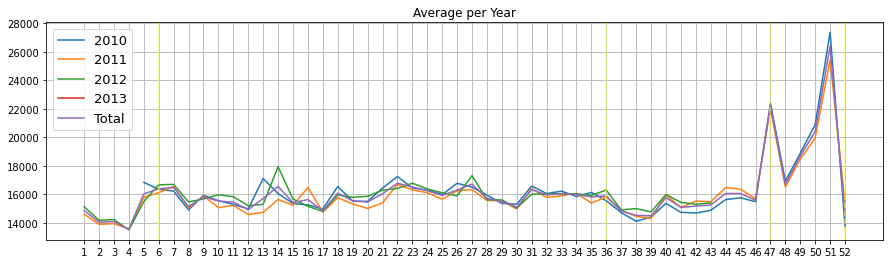

In [9]:
plt.figure(figsize = (15,4))
plt.xticks(np.arange(1, 53, step=1))

for year in range(2010,2014):
    AvgPerYear = data[(data['Year'] == year)].groupby(by = ['Week']).mean()['Weekly_Sales']
    plt.plot(AvgPerYear.index,AvgPerYear.values)

Avg = data.groupby(by = ['Week']).mean()['Weekly_Sales']
plt.plot(Avg.index,Avg.values)    

plt.legend(['2010', '2011', '2012','2013','Total'], fontsize=13)
    
for week in [6,36,47,52]:
    plt.axvline(x=week,color ='yellow',linestyle ="--",alpha=0.7)

plt.title('Average per Year')
    
plt.grid()
plt.show()

From this graph two important conclusions are drawn:
* Shopping before Christmas (week 51) is bigger than Christmas itself (week 52) which makes a lot of sense. 
* The area between week 13 and week 16 looks a little weird because the date does not include the Easter day.

Following these conclusions, we will add Easter to the data (where the weekly column does depend on the year) and make week 51 a holiday instead of week 52.

In [10]:
EasterDayDate = [
    (2010,datetime.date(2010,4,4).isocalendar()[1]),
    (2011,datetime.date(2011,4,24).isocalendar()[1]),
    (2012,datetime.date(2012,4,8).isocalendar()[1]),
    (2013,datetime.date(2013,3,31).isocalendar()[1])
]

for year,week in EasterDayDate:
    data.loc[(data['Week'] == week) & (data['Year'] == year), 'IsHoliday'] = 1
    
data.loc[data['Week'] == 52, 'IsHoliday'] = 0
data.loc[data['Week'] == 51, 'IsHoliday'] = 1

# Stores & departments analysis
Now we need to look at the overall picture of the entire time sequence.

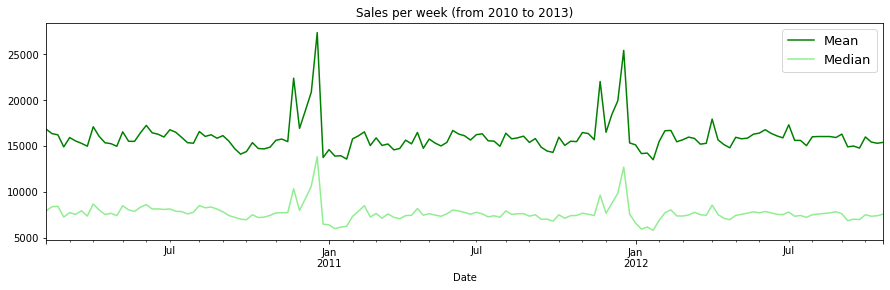

In [11]:
plt.figure(figsize = (15,4))

data.groupby(by = ['Date']).mean()['Weekly_Sales'].plot(color="green")
data.groupby(by = ['Date']).median()['Weekly_Sales'].plot(color="lightgreen")

plt.legend(['Mean', 'Median'], loc='best', fontsize=13)

plt.title('Sales per week (from 2010 to 2013)')
plt.show()

As we can see there is a sequence of cyclical anomalies, should not particularly worry us as we already know these are the holidays. <br/><br/>
As mentioned, we are supposed to provide a forecast according to store and department, let's see if this is necessary at all? Is there a difference between one store / department and another?

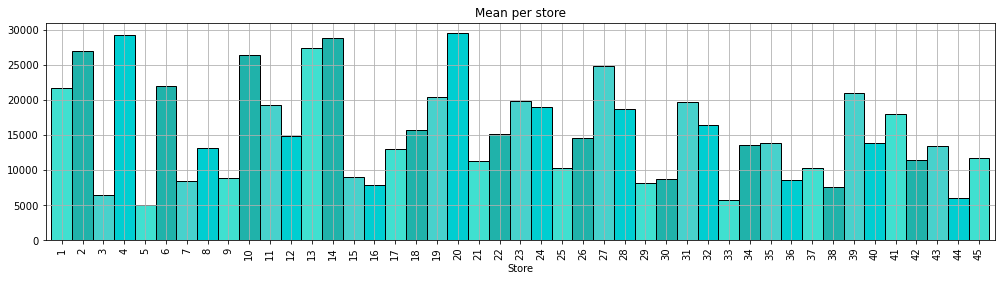

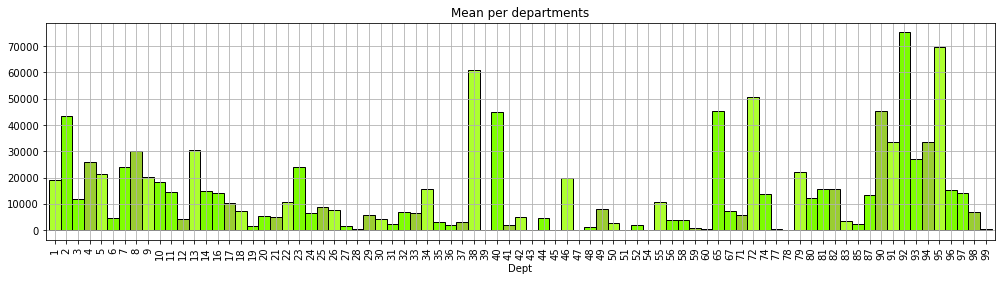

In [12]:
plt.figure(figsize = (17,4))
data.groupby(by = ['Store']).mean()['Weekly_Sales'].plot.bar(width =1,edgecolor ="black",color=["turquoise","lightseagreen","mediumturquoise","darkturquoise"])
plt.grid()
plt.title("Mean per store")
plt.show()

plt.figure(figsize = (17,4))
data.groupby(by = ['Dept']).mean()['Weekly_Sales'].plot.bar(width =1,edgecolor ="black",color=["greenyellow","lawngreen","chartreuse","yellowgreen"])
plt.grid()
plt.title("Mean per departments")
plt.show()

As we can see, sales are indeed different depending on the store and department, so these are important features and not all data can be included as a classic time series, but as one that contains features.

# Correlation analysis
Let's see what happens to the additional features that are not department or store, are they necessary for the model or will they just cause problems?

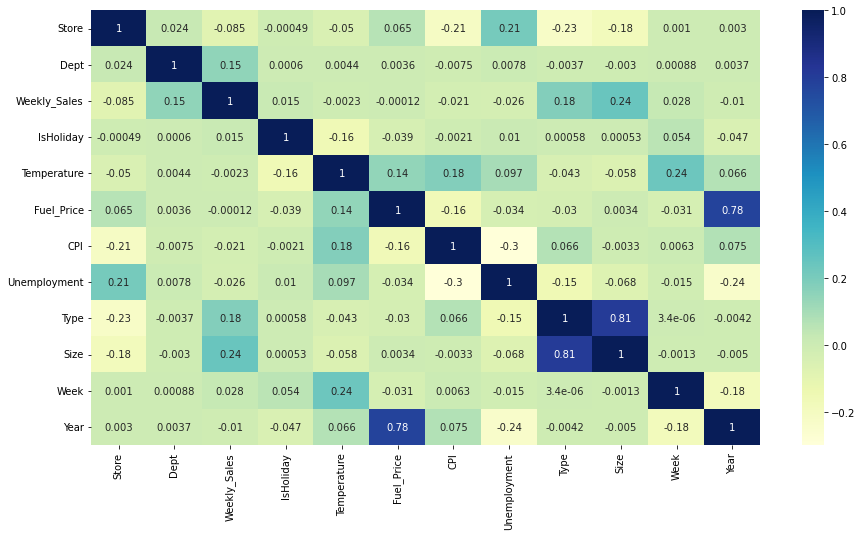

In [13]:
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(), annot=True,cmap="YlGnBu")
plt.show()

Well, there is no feature with too strong a correlation with the 'Weekly_Sales', probably the combination is what creates a strong correlation, and yet, the 'Fuel_Price' feature has such a weak correlation that it is hard to believe that it contributes to the prediction of anything.

In [14]:
data = data.drop(columns = 'Fuel_Price')

It is now necessary to examine whether the categorical and hierarchical columns affect sales.

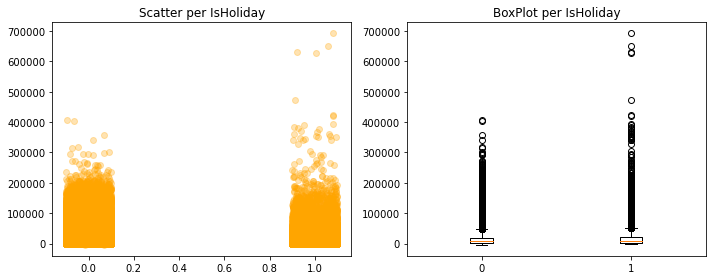

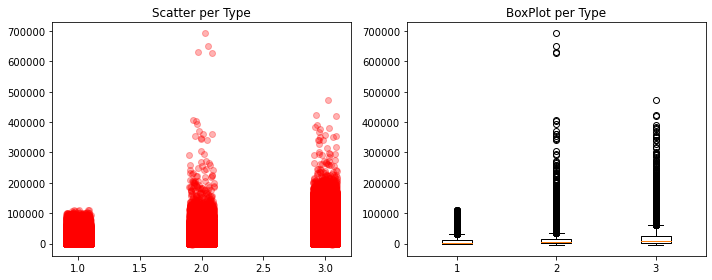

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].set_title('Scatter per IsHoliday')
axes[1].set_title('BoxPlot per IsHoliday')

axes[0].scatter(data['IsHoliday'].apply(lambda x: x + random.uniform(-0.1, 0.1)),data['Weekly_Sales'], alpha=0.3, color = 'orange')
axes[1].boxplot([data[data['IsHoliday'] == 0]['Weekly_Sales'],data[data['IsHoliday'] == 1]['Weekly_Sales']])
plt.xticks([1, 2], ['0', '1'])
fig.tight_layout()

##############################################################

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].set_title('Scatter per Type')
axes[1].set_title('BoxPlot per Type')

axes[0].scatter(data['Type'].apply(lambda x: x + random.uniform(-0.1, 0.1)),data['Weekly_Sales'], alpha=0.3, color ='red')
axes[1].boxplot([data[data['Type'] == 1]['Weekly_Sales'],
                 data[data['Type'] == 2]['Weekly_Sales'],
                 data[data['Type'] == 3]['Weekly_Sales']])

fig.tight_layout()


It is easy to see that during the holiday people buy more, as in 'Type' a (with some outliers in 'Type b', but after all 'Type a' is more popular), so these are important features and we will keep them. <br/><br/>
There are still more numerical features to check:
* Temperature
* CPI
* Unemployment
* Size

In [16]:
def dist_plot(title, colors = ['red','red']):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    axes[0].set_title("Scatter per {} (Corr = {:.2f})".format(title,data[[title,'Weekly_Sales']].corr().iloc[0,1]))
    axes[1].set_title('Distribution per ' + title)
    
    axes[0].scatter(data[title],data['Weekly_Sales'], alpha=0.3, color =colors[0], edgecolors='black')
    axes[1] = sns.distplot(data[title], color = colors[1], bins = 30, hist_kws=dict(edgecolor="white", linewidth=1))
    
    fig.tight_layout()

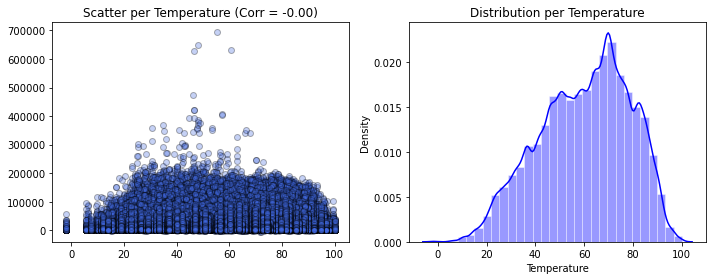

In [17]:
dist_plot('Temperature',['royalblue','b'])

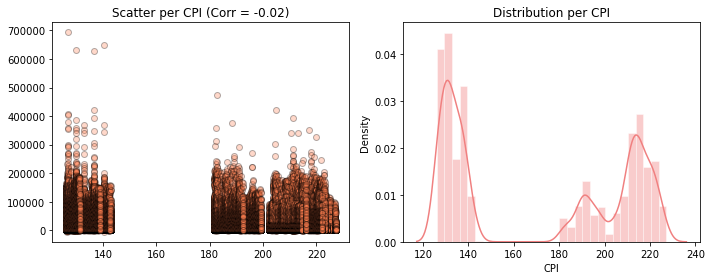

In [18]:
dist_plot('CPI',['coral','lightcoral'])

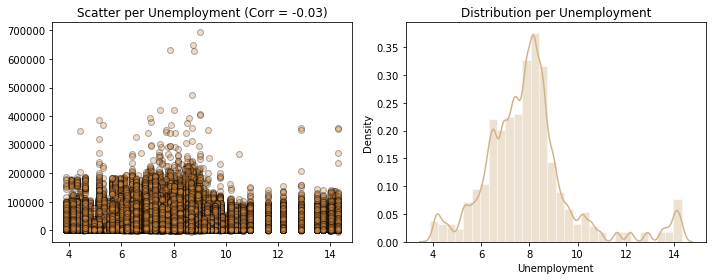

In [19]:
dist_plot('Unemployment',['peru','tan'])

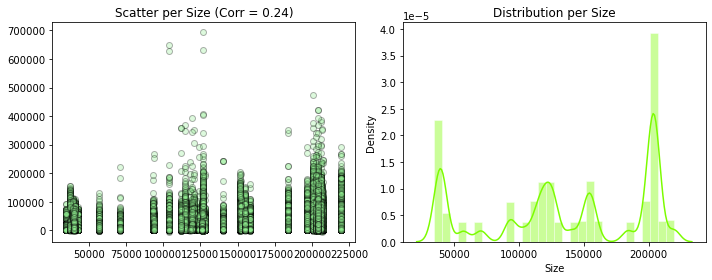

In [20]:
dist_plot('Size',['lightgreen','lawngreen'])

As we observed in the correlation matrix, it does not appear that one of the features creates a strong relationship with the sales (except for the size shown in the left graph because there is something reminiscent of a normal distribution).

In [21]:
data = data.drop(columns = ['Temperature','CPI','Unemployment'])
data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Week,Year
Date,,,,,,,,
2010-02-05,1,1,24924.50,0,3,151315,5,2010
2010-02-05,35,3,14612.19,0,2,103681,5,2010
2010-02-05,35,4,26323.15,0,2,103681,5,2010
2010-02-05,35,5,36414.63,0,2,103681,5,2010
2010-02-05,35,6,11437.81,0,2,103681,5,2010


Just checking before training...

In [22]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday         int64
Type              int64
Size              int64
Week             UInt32
Year              int64
dtype: object

I guess there is no reason to let the model deal with strange data types, so we will convert from UInt32 to int 32.

In [23]:
data['Week'] = data['Week'].astype('int32')

# Machine Learning
After cleaning the data we will divide it into train set and test set.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                        data.drop(columns = 'Weekly_Sales'), 
                                        data['Weekly_Sales'], 
                                        test_size=0.30, 
                                        random_state=42)

Since this is a tabular data without a structure that is too clear, such as linear spheribility, it is worth using a model with a good resume for tabular data like __Xgboost__. <br/>
We will examine four different combinations of hyparemeters and we will take the combination who brings to minimum RMSE loss function.

In [25]:
n_estimators = [375, 400]
max_depth = [15, 20]

results = []

for i in n_estimators:
    for j in max_depth:
        xgb_r = xg.XGBRegressor(n_estimators=i, max_depth=j, learning_rate=0.35, n_jobs=-1, random_state=42)
        xgb_r.fit(X_train, y_train)
        pred = xgb_r.predict(X_test)
        err = np.sqrt(MSE(y_test, pred))
        
        print("{} estimators.".format(i))
        print("{} as max depht.".format(j))
        print("RMSE : % f." %(err))
        print("\n")
        
        results.append((i,j,err))

375 estimators.
15 as max depht.
RMSE :  1847.202808.


375 estimators.
20 as max depht.
RMSE :  1944.470506.


400 estimators.
15 as max depht.
RMSE :  1847.517971.


400 estimators.
20 as max depht.
RMSE :  1944.470406.




Look like that 375 estimators and 15 as max depth give the best result.

In [26]:
xgb_r = xg.XGBRegressor(n_estimators=375, max_depth=15, learning_rate=0.35, n_jobs=-1, random_state=42)
xgb_r.fit(data.drop(columns = 'Weekly_Sales'), data['Weekly_Sales'])

We will now build a function for dealing with new data so that it works exactly like the original data of the model.

In [27]:
def cleanData(df):
    df = pd.merge(df,features,on=['Store','Date','IsHoliday'])
    df = pd.merge(df,stores,on=['Store'])


    df['Date'] = pd.to_datetime(df['Date'])

    df['Week'] = df['Date'].dt.isocalendar().week
    df['Year'] = df['Date'].dt.year

    df.index = df['Date']
    df = df.drop(columns = ['Date'])

    df['IsHoliday'].replace({False: 0, True: 1}, inplace=True)
    df['Type'].replace({'A': 3, 'B': 2, 'C': 1}, inplace=True) #A > B > C
    
    df = df.drop(columns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature','CPI','Unemployment','Fuel_Price'])
    
    df.loc[data['Week'] == 52, 'IsHoliday'] = 0
    df.loc[data['Week'] == 51, 'IsHoliday'] = 1
    
    for year,week in EasterDayDate:
        df.loc[(data['Week'] == week) & (data['Year'] == year), 'IsHoliday'] = 1
        
    return df

newData = pd.read_csv("data/test.csv")
newData = cleanData(newData)

prediction = xgb_r.predict(newData)

We seem to have finished here, hasta luego!